<a href="https://colab.research.google.com/github/Y4-Deep-Learning-Assignment/Pneumonia-_Detection/blob/EfficientNetB0-Dhanuka/pneumonia_effientNetB8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Oct 11 12:45:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check GPU availability
print("\nGPU Available:", tf.test.is_gpu_available())
if tf.test.is_gpu_available():
    print("GPU Device:", tf.test.gpu_device_name())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



GPU Available: True
GPU Device: /device:GPU:0


In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check your Drive structure
!ls "/content/drive/MyDrive/"

# Common locations - adjust based on where you uploaded your dataset
possible_paths = [
    '/content/drive/MyDrive/chest_xray'  # Add your specific path here
]

# Find the correct path
dataset_path = None
for path in possible_paths:
    if os.path.exists(path):
        dataset_path = path
        print(f"✅ Dataset found at: {path}")
        break

if dataset_path is None:
    print("❌ Dataset not found in common locations.")
    print("Please specify the exact path to your dataset:")
    # You can set it manually like this:
    # dataset_path = '/content/drive/MyDrive/your_folder_name/chest_xray'
else:
    # Verify the dataset structure
    def verify_dataset_structure(path):
        print("\n📁 Verifying dataset structure...")
        expected_dirs = ['train', 'test', 'val']
        expected_classes = ['NORMAL', 'PNEUMONIA']

        for split in expected_dirs:
            split_path = os.path.join(path, split)
            if os.path.exists(split_path):
                print(f"\n📂 {split}/")
                for class_name in expected_classes:
                    class_path = os.path.join(split_path, class_name)
                    if os.path.exists(class_path):
                        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                        print(f"   ├── {class_name}: {len(images)} images")
                    else:
                        print(f"   ├── {class_name}: ❌ NOT FOUND")
            else:
                print(f"\n📂 {split}/: ❌ NOT FOUND")

    verify_dataset_structure(dataset_path)

# If dataset_path is still None, set it manually:
# dataset_path = '/content/drive/MyDrive/your_exact_folder_path'

'1st page answer.gdoc'
'4th page answer.gdoc'
'a (1).pdf'
 Activity2.gdoc
 Activity_3.gdoc
 a.gdoc
 a.pdf
'Assignment 01 - CSSE.docx'
 bank.gdoc
 BOCDownload_9_8_202415_55_53.pdf
'chardrika anti bank details (1).gdoc'
'chardrika anti bank details (2).gdoc'
'chardrika anti bank details (3).gdoc'
'chardrika anti bank details.gdoc'
'chardrika anti bank details.txt'
 chart.png
 chest_xray
'Colab Notebooks'
'Contact Information.gform'
'Copy of 2012_physics_II.pdf'
'Copy of Co-planar Forces_1.pdf'
'Dhanuka (1)-1 (1).pdf'
'Dhanuka (1)-1.pdf'
'Dhanuka Navodya Cover Letter.pdf'
'Dhanuka Navodya CV.pdf'
'Dhanuka Navodya-SLIIT.pdf'
'Dhanuka .pdf'
 Dhanuka.pdf
'DOC-20230611-WA0002. (1).gdoc'
 DOC-20230611-WA0002..gdoc
 DOC-20240210-WA0014..gdoc
'Document from Dhanuka Navodya'
'D.P.D.Dhanuka Navodya.pdf'
'eventhivedb (1).gdoc'
 eventhivedb.gdoc
 Files.zip
'Final_ITP24_B11_06[1].gdoc'
'Getting started.pdf'
 gf
'Google AI Studio'
'Google AI Studio (1)'
 HotelManaementDB.gdoc
'ILUK Backup'
 img
 IMG_2

In [ ]:
# Set dataset paths
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
val_dir = os.path.join(dataset_path, 'val')

print("Dataset paths:")
print(f"Training: {train_dir}")
print(f"Testing: {test_dir}")
print(f"Validation: {val_dir}")

# Check if validation directory exists, if not we'll handle it
if not os.path.exists(val_dir) or len(os.listdir(val_dir)) == 0:
    print("⚠️  Validation directory not found or empty. We'll create one from training data.")

Dataset paths:
Training: /content/drive/MyDrive/chest_xray/train
Testing: /content/drive/MyDrive/chest_xray/test
Validation: /content/drive/MyDrive/chest_xray/val


In [ ]:
# Set parameters
IMG_SIZE = (300, 300)  # EfficientNetB3 default input size
BATCH_SIZE = 16
EPOCHS = 30
NUM_CLASSES = 2

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=0.2  # We'll use this if no validation directory
)

# Validation and test data generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
if os.path.exists(val_dir) and len(os.listdir(val_dir)) > 0:
    # Use existing validation directory
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
else:
    # Create validation split from training data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        subset='validation'
    )

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Data generators created successfully!")
print(f"Class indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

✅ Data generators created successfully!
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624


Training samples preview:


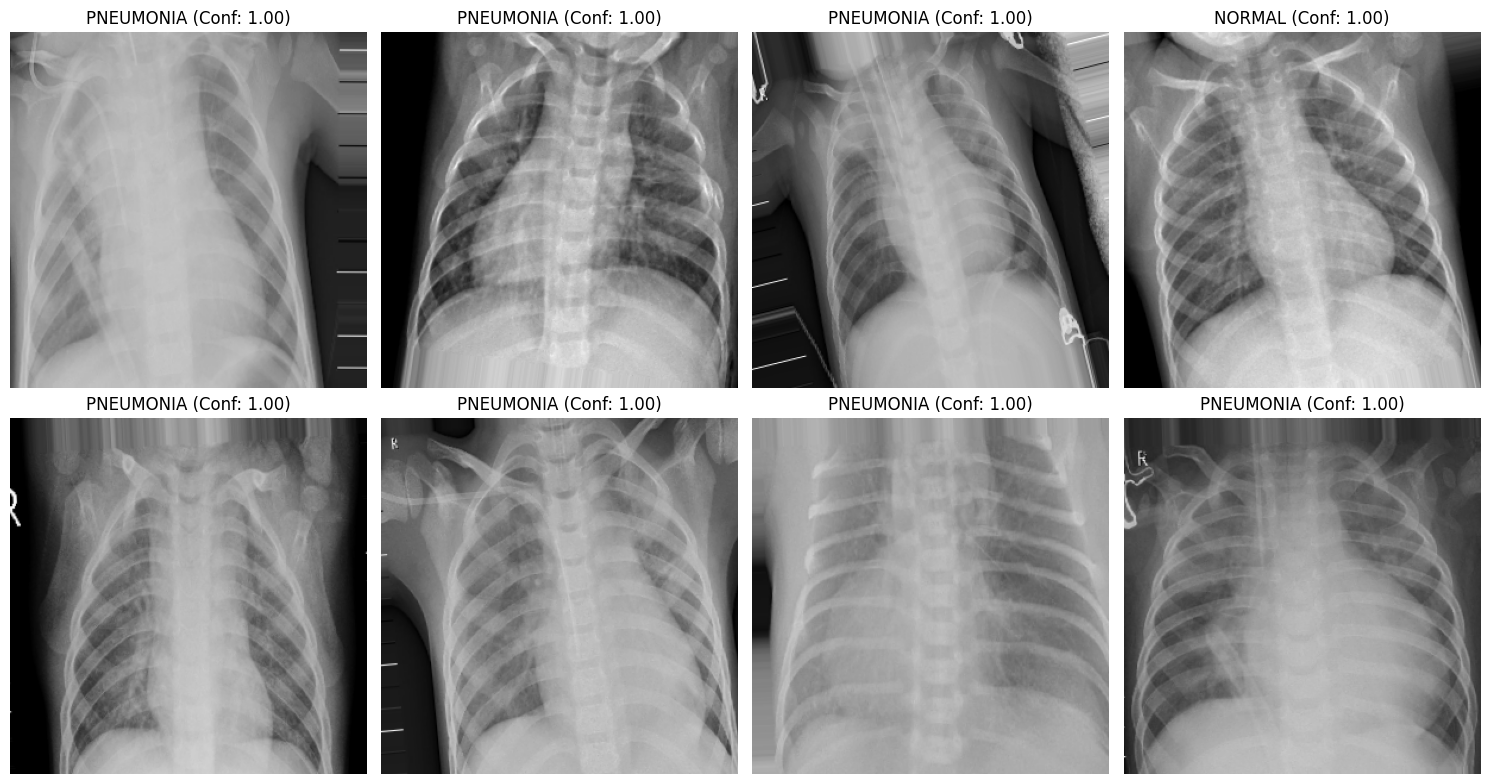

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [ ]:
# Display sample images from the dataset
def visualize_samples(generator, num_samples=8):
    class_names = list(generator.class_indices.keys())

    # Get a batch of data
    images, labels = next(generator)

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(images[i])
        label_idx = np.argmax(labels[i])
        confidence = labels[i][label_idx]
        axes[i].set_title(f'{class_names[label_idx]} (Conf: {confidence:.2f})')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Training samples preview:")
visualize_samples(train_generator)

# Calculate class weights for handling imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

In [ ]:
def create_efficientnet_model(num_classes=2):
    """
    Create EfficientNetB3 model with custom classifier
    """
    # Load pre-trained EfficientNetB3
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(300, 300, 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Build custom classifier
    inputs = tf.keras.Input(shape=(300, 300, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Additional layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

# Create and compile model
print("Creating EfficientNetB3 model...")
model, base_model = create_efficientnet_model(NUM_CLASSES)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("✅ Model created successfully!")
model.summary()

Creating EfficientNetB3 model...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✅ Model created successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,705,393 (44.65 MB)

 Trainable params: 920,322 (3.51 MB)

 Non-trainable params: 10,785,071 (41.14 MB)

In [ ]:
# Create callbacks
callbacks = [
    ModelCheckpoint(
        '/content/best_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    CSVLogger('/content/training_log.csv')
]

print("✅ Callbacks setup completed!")

✅ Callbacks setup completed!


In [ ]:
# Calculate steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
val_steps = val_generator.samples // BATCH_SIZE

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

# Phase 1: Train with frozen base layers
print("🚀 Starting Phase 1: Feature Extraction (Frozen Base)...")

history1 = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Training steps per epoch: 326
Validation steps per epoch: 1
🚀 Starting Phase 1: Feature Extraction (Frozen Base)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5597 - loss: 0.8983 - precision: 0.5597 - recall: 0.5597 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/best_pneumonia_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 3373s 10s/step - accuracy: 0.5598 - loss: 0.8980 - precision: 0.5598 - recall: 0.5598 - val_accuracy: 0.5000 - val_loss: 1.2046 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.6061 - loss: 0.7271 - precision: 0.6061 - recall: 0.6061
Epoch 2: val_accuracy improved from 0.50000 to 0.68750, saving model to /content/best_pneumonia_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 192s 590ms/step - accuracy: 0.6061 - loss: 0.7271 - precision: 0.6061 - recall: 0.6061 - val_accuracy: 0.6875 - val_loss: 0.6245 - val_precision: 0.6875 - val_recall: 0.6875 - learning_rate: 0.0010
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.6219 - loss: 0.6901 - precision: 0.6219 - recall: 0.6219
Epoch 3: val_accuracy did not improve from 0.68750
326/326 ━━━━━━━━━━━━━━━━━━━━ 188s 576ms/step - accuracy: 0.6219 - loss: 0.6901 - precision: 0.6219 - recall: 0.6219 - val_accuracy: 0.5625 - val_loss: 0.6753 - val_precision: 0.5625 - val_recall: 0.5625 - learning_rate: 0.0010
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.6388 - loss: 0.6652 - precision: 0.6388 - recall: 0.6388
Epoch 4: val_accuracy did not improve from 0.68750
326/326 ━━━━━━━━━━━━━━━━━━━━ 188s 576ms/step - accuracy: 0.6389 - loss: 0.6651 - precision: 0.6389 - recall: 0.6389 - val_accuracy: 0.5000 - val_loss: 0.6309 - val_precision: 0.5000 - val_recall

In [ ]:
# Phase 2: Fine-tuning
print("🔧 Starting Phase 2: Fine-tuning...")

# Unfreeze base model layers
base_model.trainable = True

# Freeze first 150 layers, fine-tune the rest
for layer in base_model.layers[:150]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001/10),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Continue training
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

🔧 Starting Phase 2: Fine-tuning...
Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.6724 - loss: 0.6535 - precision: 0.6724 - recall: 0.6724
Epoch 1: val_accuracy did not improve from 0.68750
326/326 ━━━━━━━━━━━━━━━━━━━━ 304s 638ms/step - accuracy: 0.6724 - loss: 0.6533 - precision: 0.6724 - recall: 0.6724 - val_accuracy: 0.5625 - val_loss: 0.5446 - val_precision: 0.5625 - val_recall: 0.5625 - learning_rate: 1.0000e-05
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.7292 - loss: 0.5275 - precision: 0.7292 - recall: 0.7292
Epoch 2: val_accuracy did not improve from 0.68750
326/326 ━━━━━━━━━━━━━━━━━━━━ 198s 607ms/step - accuracy: 0.7293 - loss: 0.5274 - precision: 0.7293 - recall: 0.7293 - val_accuracy: 0.6875 - val_loss: 0.5096 - val_precision: 0.6875 - val_recall: 0.6875 - learning_rate: 1.0000e-05
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.7481 - loss: 0.4741 - precision: 0.7481 - recall: 0.7481
Epoch 3: val_accuracy did 

326/326 ━━━━━━━━━━━━━━━━━━━━ 203s 623ms/step - accuracy: 0.7730 - loss: 0.4288 - precision: 0.7730 - recall: 0.7730 - val_accuracy: 0.8750 - val_loss: 0.3212 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-05
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7915 - loss: 0.4212 - precision: 0.7915 - recall: 0.7915
Epoch 6: val_accuracy did not improve from 0.87500
326/326 ━━━━━━━━━━━━━━━━━━━━ 198s 608ms/step - accuracy: 0.7915 - loss: 0.4212 - precision: 0.7915 - recall: 0.7915 - val_accuracy: 0.8750 - val_loss: 0.3520 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-05
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7992 - loss: 0.4003 - precision: 0.7992 - recall: 0.7992
Epoch 7: val_accuracy did not improve from 0.87500
326/326 ━━━━━━━━━━━━━━━━━━━━ 200s 614ms/step - accuracy: 0.7992 - loss: 0.4003 - precision: 0.7992 - recall: 0.7992 - val_accuracy: 0.8750 - val_loss: 0.2833 - val_precision: 0.8750 - va

326/326 ━━━━━━━━━━━━━━━━━━━━ 189s 581ms/step - accuracy: 0.8283 - loss: 0.3582 - precision: 0.8283 - recall: 0.8283 - val_accuracy: 1.0000 - val_loss: 0.1828 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 11/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8330 - loss: 0.3532 - precision: 0.8330 - recall: 0.8330
Epoch 11: val_accuracy did not improve from 1.00000
326/326 ━━━━━━━━━━━━━━━━━━━━ 189s 578ms/step - accuracy: 0.8330 - loss: 0.3532 - precision: 0.8330 - recall: 0.8330 - val_accuracy: 0.9375 - val_loss: 0.2803 - val_precision: 0.9375 - val_recall: 0.9375 - learning_rate: 1.0000e-05
Epoch 12/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8419 - loss: 0.3461 - precision: 0.8419 - recall: 0.8419
Epoch 12: val_accuracy did not improve from 1.00000
326/326 ━━━━━━━━━━━━━━━━━━━━ 204s 587ms/step - accuracy: 0.8419 - loss: 0.3462 - precision: 0.8419 - recall: 0.8419 - val_accuracy: 0.9375 - val_loss: 0.2020 - val_precision: 0.9375 

In [ ]:
# Save the final model to Drive
model.save('/content/drive/MyDrive/pneumonia_model_final.h5')
print("✅ Final model saved to Google Drive!")

# Save training history
history_df = pd.DataFrame({
    'epoch': range(1, len(history1.history['accuracy']) + len(history2.history['accuracy']) + 1),
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss']
})

history_df.to_csv('/content/drive/MyDrive/training_history.csv', index=False)
print("✅ Training history saved to Google Drive!")

# Download files to local machine (optional)
from google.colab import files
files.download('/content/best_pneumonia_model.h5')
print("✅ Best model downloaded to your local machine!")

✅ Final model saved to Google Drive!
✅ Training history saved to Google Drive!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Best model downloaded to your local machine!


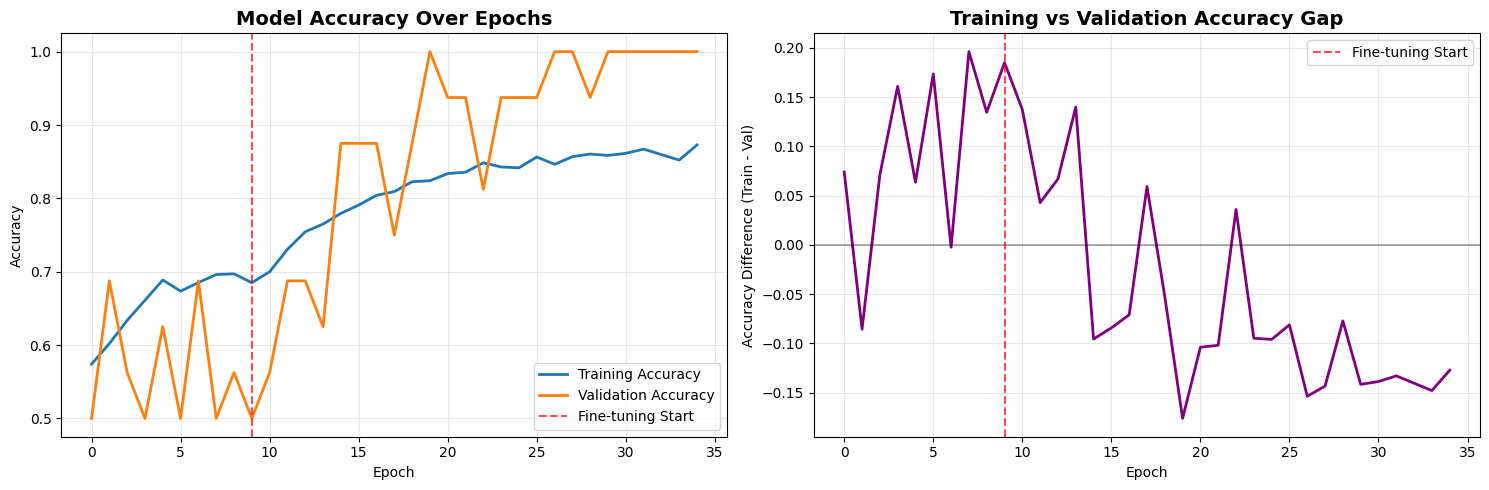

In [ ]:
# Combine both training phases
def combine_histories(history1, history2):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    return combined_history

# Combine the histories from both training phases
combined_history = combine_histories(history1, history2)

# Create comprehensive accuracy plots
plt.figure(figsize=(15, 5))

# Plot 1: Training vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Mark the phase transition
phase_transition = len(history1.history['accuracy'])
plt.axvline(x=phase_transition-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
plt.legend()

# Plot 2: Accuracy Difference
plt.subplot(1, 2, 2)
accuracy_diff = [train - val for train, val in zip(combined_history['accuracy'], combined_history['val_accuracy'])]
plt.plot(accuracy_diff, color='purple', linewidth=2)
plt.title('Training vs Validation Accuracy Gap', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Difference (Train - Val)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.axvline(x=phase_transition-1, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Detailed accuracy analysis
print("📊 DETAILED ACCURACY ANALYSIS")
print("=" * 50)

# Final accuracy values
final_train_acc = combined_history['accuracy'][-1]
final_val_acc = combined_history['val_accuracy'][-1]
best_val_acc = max(combined_history['val_accuracy'])
best_val_epoch = combined_history['val_accuracy'].index(best_val_acc) + 1

print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) at epoch {best_val_epoch}")
print(f"Accuracy Gap (Train - Val): {final_train_acc - final_val_acc:.4f}")

# Phase 1 vs Phase 2 analysis
phase1_train_acc = history1.history['accuracy'][-1]
phase1_val_acc = history1.history['val_accuracy'][-1]
phase2_train_acc = history2.history['accuracy'][-1]
phase2_val_acc = history2.history['val_accuracy'][-1]

print(f"\n🔄 PHASE COMPARISON:")
print(f"Phase 1 (Frozen) - Train: {phase1_train_acc:.4f}, Val: {phase1_val_acc:.4f}")
print(f"Phase 2 (Fine-tuned) - Train: {phase2_train_acc:.4f}, Val: {phase2_val_acc:.4f}")
print(f"Improvement after fine-tuning: +{(phase2_val_acc - phase1_val_acc):.4f}")

📊 DETAILED ACCURACY ANALYSIS
Final Training Accuracy: 0.8729 (87.29%)
Final Validation Accuracy: 1.0000 (100.00%)
Best Validation Accuracy: 1.0000 (100.00%) at epoch 20
Accuracy Gap (Train - Val): -0.1271

🔄 PHASE COMPARISON:
Phase 1 (Frozen) - Train: 0.6850, Val: 0.5000
Phase 2 (Fine-tuned) - Train: 0.8729, Val: 1.0000
Improvement after fine-tuning: +0.5000


In [ ]:
# Interactive plot with Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive accuracy plot
fig = make_subplots(rows=2, cols=2,
                   subplot_titles=('Training vs Validation Accuracy',
                                  'Accuracy Progress Over Time',
                                  'Accuracy Difference (Train - Val)',
                                  'Accuracy Distribution by Phase'),
                   specs=[[{"secondary_y": False}, {"secondary_y": False}],
                          [{"secondary_y": False}, {"secondary_y": False}]])

# Plot 1: Training vs Validation Accuracy
fig.add_trace(
    go.Scatter(y=combined_history['accuracy'], name="Training Accuracy",
               line=dict(color='blue', width=3)),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=combined_history['val_accuracy'], name="Validation Accuracy",
               line=dict(color='red', width=3)),
    row=1, col=1
)

# Plot 2: Smoothed accuracy
window = 3
smoothed_train = [np.mean(combined_history['accuracy'][i:i+window])
                  for i in range(len(combined_history['accuracy'])-window+1)]
smoothed_val = [np.mean(combined_history['val_accuracy'][i:i+window])
                for i in range(len(combined_history['val_accuracy'])-window+1)]

fig.add_trace(
    go.Scatter(y=smoothed_train, name="Smoothed Train",
               line=dict(color='lightblue', width=2, dash='dash')),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(y=smoothed_val, name="Smoothed Val",
               line=dict(color='pink', width=2, dash='dash')),
    row=1, col=2
)

# Plot 3: Accuracy difference
fig.add_trace(
    go.Scatter(y=accuracy_diff, name="Accuracy Gap",
               line=dict(color='purple', width=2)),
    row=2, col=1
)

# Plot 4: Phase comparison
phases = ['Phase 1 Start', 'Phase 1 End', 'Phase 2 End']
phase_accuracies = [
    combined_history['accuracy'][0],
    combined_history['accuracy'][phase_transition-1],
    combined_history['accuracy'][-1]
]

fig.add_trace(
    go.Bar(x=phases, y=phase_accuracies, name="Training Accuracy by Phase",
           marker_color=['green', 'orange', 'red']),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Comprehensive Accuracy Analysis", showlegend=True)
fig.show()

In [ ]:
# Create detailed accuracy statistics
import pandas as pd

accuracy_stats = {
    'Metric': [
        'Initial Training Accuracy',
        'Final Training Accuracy',
        'Best Training Accuracy',
        'Initial Validation Accuracy',
        'Final Validation Accuracy',
        'Best Validation Accuracy',
        'Overall Improvement',
        'Final Accuracy Gap'
    ],
    'Value': [
        f"{combined_history['accuracy'][0]:.4f} ({combined_history['accuracy'][0]*100:.2f}%)",
        f"{final_train_acc:.4f} ({final_train_acc*100:.2f}%)",
        f"{max(combined_history['accuracy']):.4f} ({max(combined_history['accuracy'])*100:.2f}%)",
        f"{combined_history['val_accuracy'][0]:.4f} ({combined_history['val_accuracy'][0]*100:.2f}%)",
        f"{final_val_acc:.4f} ({final_val_acc*100:.2f}%)",
        f"{best_val_acc:.4f} ({best_val_acc*100:.2f}%)",
        f"+{(final_val_acc - combined_history['val_accuracy'][0]):.4f}",
        f"{final_train_acc - final_val_acc:.4f}"
    ],
    'Epoch': [
        '1',
        str(len(combined_history['accuracy'])),
        str(combined_history['accuracy'].index(max(combined_history['accuracy'])) + 1),
        '1',
        str(len(combined_history['val_accuracy'])),
        str(best_val_epoch),
        'N/A',
        'N/A'
    ]
}

accuracy_df = pd.DataFrame(accuracy_stats)
print("📈 ACCURACY STATISTICS")
print("=" * 70)
print(accuracy_df.to_string(index=False))

📈 ACCURACY STATISTICS
                     Metric            Value Epoch
  Initial Training Accuracy  0.5740 (57.40%)     1
    Final Training Accuracy  0.8729 (87.29%)    35
     Best Training Accuracy  0.8729 (87.29%)    35
Initial Validation Accuracy  0.5000 (50.00%)     1
  Final Validation Accuracy 1.0000 (100.00%)    35
   Best Validation Accuracy 1.0000 (100.00%)    20
        Overall Improvement          +0.5000   N/A
         Final Accuracy Gap          -0.1271   N/A


In [ ]:
# Create epoch-by-epoch progress table
epochs = range(1, len(combined_history['accuracy']) + 1)

progress_data = {
    'Epoch': epochs,
    'Train_Accuracy': [f"{acc:.4f}" for acc in combined_history['accuracy']],
    'Val_Accuracy': [f"{acc:.4f}" for acc in combined_history['val_accuracy']],
    'Difference': [f"{(t-v):.4f}" for t, v in zip(combined_history['accuracy'], combined_history['val_accuracy'])],
    'Improvement': ['Start'] + [f"+{(combined_history['accuracy'][i] - combined_history['accuracy'][i-1]):.4f}"
                               for i in range(1, len(combined_history['accuracy']))]
}

progress_df = pd.DataFrame(progress_data)

# Display first 10 and last 10 epochs
print("🔄 EPOCH-BY-EPOCH ACCURACY PROGRESS")
print("=" * 80)
print("First 10 Epochs:")
print(progress_df.head(10).to_string(index=False))
print("\nLast 10 Epochs:")
print(progress_df.tail(10).to_string(index=False))

# Highlight best epochs
print(f"\n⭐ BEST PERFORMING EPOCHS:")
best_train_epoch = combined_history['accuracy'].index(max(combined_history['accuracy'])) + 1
print(f"Best Training Accuracy: Epoch {best_train_epoch} - {max(combined_history['accuracy']):.4f}")
print(f"Best Validation Accuracy: Epoch {best_val_epoch} - {best_val_acc:.4f}")

🔄 EPOCH-BY-EPOCH ACCURACY PROGRESS
First 10 Epochs:
 Epoch Train_Accuracy Val_Accuracy Difference Improvement
     1         0.5740       0.5000     0.0740       Start
     2         0.6020       0.6875    -0.0855     +0.0280
     3         0.6336       0.5625     0.0711     +0.0316
     4         0.6610       0.5000     0.1610     +0.0274
     5         0.6887       0.6250     0.0637     +0.0276
     6         0.6735       0.5000     0.1735    +-0.0151
     7         0.6852       0.6875    -0.0023     +0.0117
     8         0.6961       0.5000     0.1961     +0.0109
     9         0.6971       0.5625     0.1346     +0.0010
    10         0.6850       0.5000     0.1850    +-0.0121

Last 10 Epochs:
 Epoch Train_Accuracy Val_Accuracy Difference Improvement
    26         0.8564       0.9375    -0.0811     +0.0148
    27         0.8464       1.0000    -0.1536    +-0.0100
    28         0.8568       1.0000    -0.1432     +0.0104
    29         0.8604       0.9375    -0.0771     +0.0036
   